In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import warnings
warnings.filterwarnings('ignore')
import numpy as np


In [2]:
df = pd.read_csv('../cleaned_cpo_price.csv', index_col="Date").dropna()
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


Text(0.5, 0, 'Date')

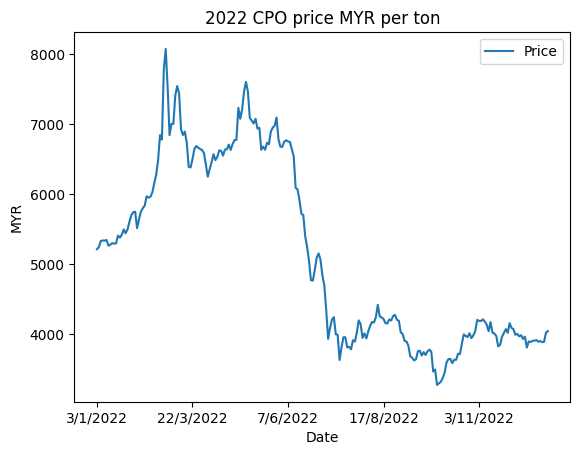

In [3]:
df.plot()
plt.title("2022 CPO price MYR per ton")
plt.ylabel("MYR")
plt.xlabel("Date")

In [4]:
pct_change = 100 * df.pct_change().dropna()
pct_change

,Price
Date,
4/1/2022,0.604143
5/1/2022,1.629969
6/1/2022,0.168824
7/1/2022,-0.074906
10/1/2022,0.206147
...,...
21/12/2022,0.218341
22/12/2022,-0.384468
23/12/2022,0.102920


<Axes: xlabel='Date'>

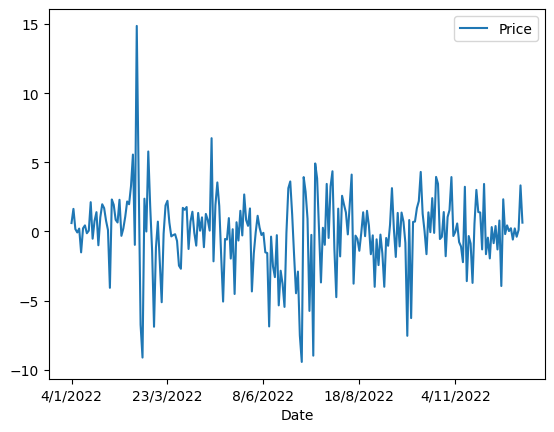

In [5]:
pct_change.plot()

In [6]:
dt_srs = list(pct_change.Price)

Text(0.5, 1.0, 'Autocorrelation Original Series')

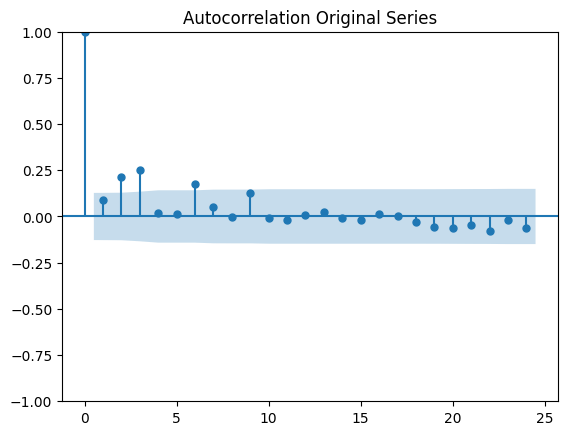

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(pct_change**2)
plt.title("Autocorrelation Original Series")

Text(0.5, 1.0, 'Partial Autocorrelation Original Series')

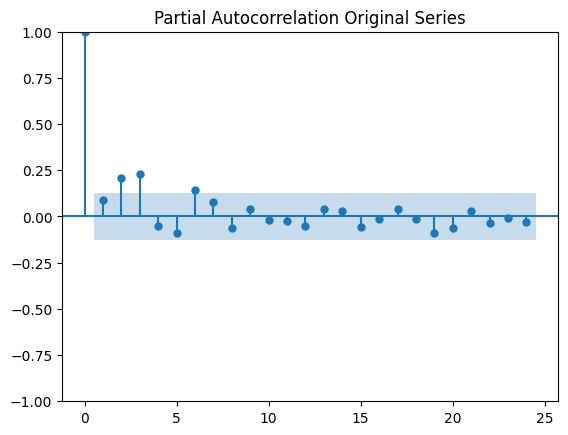

In [8]:
plot_pacf(pct_change**2)
plt.title("Partial Autocorrelation Original Series")

In [9]:
# split into train/test
from arch import arch_model
n_test = 12
train, test = dt_srs[:-n_test], dt_srs[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q =1)

# fit model
model_fit = model.fit()

# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
yhat

model_fit.summary

Iteration:      1,   Func. Count:      5,   Neg. LLF: 955.2592090503947
Iteration:      2,   Func. Count:     11,   Neg. LLF: 562.9926841916306
Iteration:      3,   Func. Count:     17,   Neg. LLF: 536.2571333688869
Iteration:      4,   Func. Count:     22,   Neg. LLF: 567.3470272863849
Iteration:      5,   Func. Count:     27,   Neg. LLF: 536.1798916863495
Iteration:      6,   Func. Count:     31,   Neg. LLF: 536.1796595314001
Iteration:      7,   Func. Count:     35,   Neg. LLF: 536.1796548014664
Iteration:      8,   Func. Count:     38,   Neg. LLF: 536.179654801359
Optimization terminated successfully    (Exit mode 0)
            Current function value: 536.1796548014664
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8


<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -536.180
Distribution:                  Normal   AIC:                           1078.36
Method:            Maximum Likelihood   BIC:                           1088.59
                                        No. Observations:                  224
Date:                Wed, Jul 12 2023   Df Residuals:                      224
Time:                        21:43:16   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.126

<Axes: >

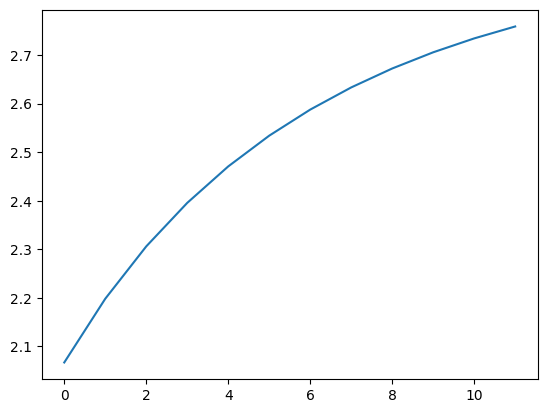

In [10]:
it = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
it.plot()

<Axes: >

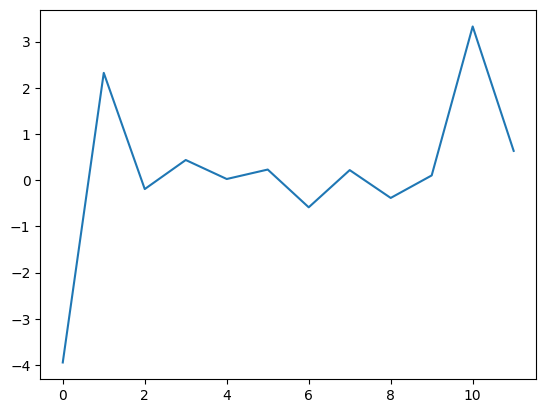

In [11]:
tt = pd.Series(test)
tt.plot()

<Axes: >

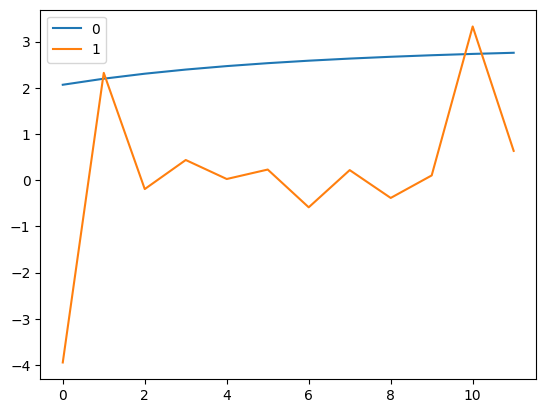

In [12]:
pd.concat([it, tt], axis=1).plot()

In [13]:
val = pd.concat([it, tt], axis=1)
val

,0,1
0,2.066591,-3.947534
1,2.197964,2.324055
2,2.305865,-0.192480
3,2.395526,0.437130
4,2.470666,0.025602
5,2.534040,0.230356
6,2.587754,-0.587334
7,2.633459,0.218341
8,2.672472,-0.384468
9,2.705856,0.102920


# one step ahead

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='GARCH', p=1, q = 1)

    # fit model
    model_fit = model.fit(disp='off')

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    err = np.sqrt(mean_squared_error(test_val, pred_)) #rmse
    return err
    
one_step_ahead(df, .8)

def loop_pct():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct()

,pct,res
0,0.80,3.397727
1,0.85,3.481707
2,0.90,3.238060
3,0.95,2.493467


In [15]:
# MAPE

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def one_step_ahead_mape(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='GARCH', p=1, q = 1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    err = mean_absolute_percentage_error(test_val, pred_) #mape
    return err
    
one_step_ahead_mape(df, .8)

def loop_pct_mape():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_mape(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_mape()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 776.4238980629094
Iteration:      2,   Func. Count:     11,   Neg. LLF: 487.52884769977175
Iteration:      3,   Func. Count:     17,   Neg. LLF: 514.5954755318357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 462.904759501093
Iteration:      5,   Func. Count:     27,   Neg. LLF: 462.90339943620864
Iteration:      6,   Func. Count:     31,   Neg. LLF: 462.9033765996727
Iteration:      7,   Func. Count:     35,   Neg. LLF: 462.90337596509505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 462.90337596509505
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 776.4238980629094
Iteration:      2,   Func. Count:     11,   Neg. LLF: 487.52884769977175
Iteration:      3,   Func. Count:     17,   Neg. LLF: 514.5954755318357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 462.90475950109

,pct,res
0,0.80,9.041860
1,0.85,8.358796
2,0.90,10.832490
3,0.95,17.594841


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_t(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='GARCH', p=1, q = 1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat_t = model_fit.forecast(horizon=len(train_))
    pred_t = pd.Series(np.sqrt(yhat_t.variance.values[-1, :]))
    
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    train_val = pd.Series(train_)
    err = np.sqrt(mean_squared_error(test_val, pred_))
    err_t = np.sqrt(mean_squared_error(train_val, pred_t)) #rmse
    return err_t, err
    
one_step_ahead_t(df, .8)

def loop_pct_t():
    dict = {'pct':[], 'train/test':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['train/test'].append(one_step_ahead_t(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_t()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 776.4238980629094


Iteration:      2,   Func. Count:     11,   Neg. LLF: 487.52884769977175
Iteration:      3,   Func. Count:     17,   Neg. LLF: 514.5954755318357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 462.904759501093
Iteration:      5,   Func. Count:     27,   Neg. LLF: 462.90339943620864
Iteration:      6,   Func. Count:     31,   Neg. LLF: 462.9033765996727
Iteration:      7,   Func. Count:     35,   Neg. LLF: 462.90337596509505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 462.90337596509505
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 776.4238980629094
Iteration:      2,   Func. Count:     11,   Neg. LLF: 487.52884769977175
Iteration:      3,   Func. Count:     17,   Neg. LLF: 514.5954755318357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 462.904759501093
Iteration:      5,   Func. Count:     27,   Neg. LLF: 462.90339943620

,pct,train/test
0,0.80,"(4.371408629871772, 3.3977268620232457)"
1,0.85,"(4.248129795553393, 3.4817065896403143)"
2,0.90,"(4.20414666430333, 3.2380600702020748)"
3,0.95,"(4.14401965016684, 2.4934673896093096)"


### Plotting 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 776.4238980629094


Iteration:      2,   Func. Count:     11,   Neg. LLF: 487.52884769977175
Iteration:      3,   Func. Count:     17,   Neg. LLF: 514.5954755318357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 462.904759501093
Iteration:      5,   Func. Count:     27,   Neg. LLF: 462.90339943620864
Iteration:      6,   Func. Count:     31,   Neg. LLF: 462.9033765996727
Iteration:      7,   Func. Count:     35,   Neg. LLF: 462.90337596509505
Optimization terminated successfully    (Exit mode 0)
            Current function value: 462.90337596509505
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7


<Axes: >

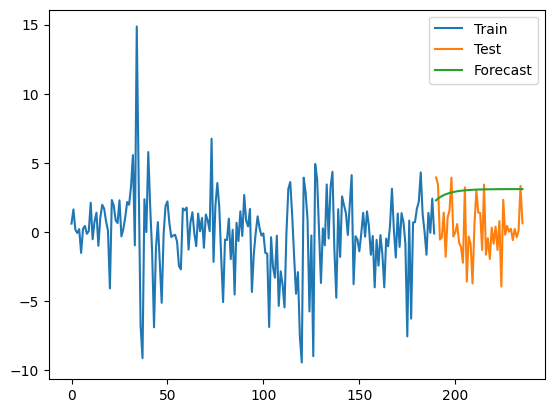

In [17]:
def plot_arch(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, mean='Zero', vol='GARCH', p=1, q = 1)

    # fit model
    model_fit = model.fit()

    # forecast the test set
    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    test_val = pd.Series(test_)
    # err = mean_absolute_percentage_error(test_val, pred_) #mape
    df_t = pd.DataFrame(train_)
    df_te = pd.DataFrame(test_)
    df_p = pd.DataFrame(pred_)
    df_res = pd.concat([df_te, df_p], axis= 1)
    df_res['index'] = range(190, 236)
    df_res.set_index(['index'], inplace=True)
    df_res = pd.concat([df_t, df_res], axis= 1)
    df_res.columns = ['Train', 'Test', 'Forecast']
    return df_res.plot()
    
plot_arch(df, .8)

<Axes: >

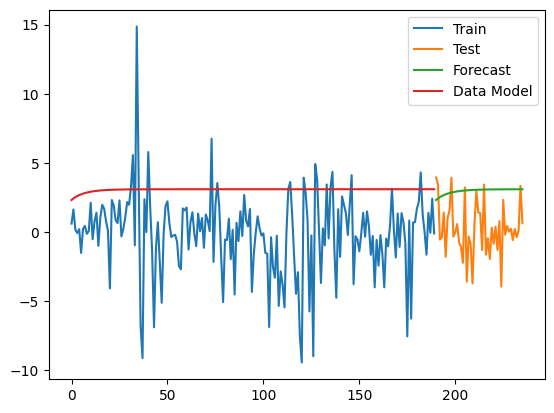

In [19]:
def plot_arch(df_, split_):
    df_cp = df_
    pct_change = 100 * df_.pct_change().dropna()
    dt_srs = list(pct_change.Price)
    size_ = round(len(df_cp)*split_)
    train_ = dt_srs[:size_]
    test_ = dt_srs[size_:]

    # define model
    model = arch_model(train_, vol='GARCH', p=1, q = 1)

    # fit model
    model_fit = model.fit(disp='off')

    # forecast the test set
    yhat_t = model_fit.forecast(horizon=len(train_))
    pred_t = pd.Series(np.sqrt(yhat_t.variance.values[-1, :]))


    yhat = model_fit.forecast(horizon=len(test_))
    pred_ = pd.Series(np.sqrt(yhat.variance.values[-1, :]))
    
    test_val = pd.Series(test_)
    # err = mean_absolute_percentage_error(test_val, pred_) #mape
    df_t = pd.DataFrame(train_)
    df_te = pd.DataFrame(test_)
    df_p = pd.DataFrame(pred_)
    df_tp = pd.DataFrame(pred_t)

    df_res = pd.concat([df_te, df_p], axis= 1)
    df_res['index'] = range(190, 236)
    df_res.set_index(['index'], inplace=True)
    df_res = pd.concat([df_t, df_res], axis= 1)
    df_res = pd.concat([df_res, df_tp], axis= 1)
    df_res.columns = ['Train', 'Test', 'Forecast', 'Data Model']
    return df_res.plot()
    
plot_arch(df, .8)